# HuggingFace PatchTST test

0. Imploementation huggingface

1. Pendulum prediction test (transfer learning)

2. Pendulum representation learning test: encoder-decoder separation (transfer learning)

3. Train simple PatchTST ??


In [1]:
# Standard librairy
import os
from pathlib import Path

# Librairies
import numpy as np
import matplotlib.pyplot as plt

# ML librairies
import torch

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' 

In [3]:
from transformers import (
    EarlyStoppingCallback,
    PatchTSTConfig,
    PatchTSTForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd

/home/ITER/brussel/Documents/ITER-transformers-for-tokamak-timeseries/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

In [5]:
from transformers import set_seed

set_seed(2023)

In [9]:
# The ECL data is available from https://github.com/zhouhaoyi/Informer2020?tab=readme-ov-file#data
dataset_path = Path().absolute().parent.parent / "./data/raw/ECL.csv"
timestamp_column = "date"
id_columns = []

context_length = 128
forecast_horizon = 48
patch_length = 16
num_workers = 8  # Reduce this if you have low number of CPU cores
batch_size = 1  # Adjust according to GPU memory

In [10]:
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)
forecast_columns = list(data.columns[1:])

# get split
num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

train_start_index = border1s[0]  # None indicates beginning of dataset
train_end_index = border2s[0]

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
valid_start_index = border1s[1]
valid_end_index = border2s[1]

test_start_index = border1s[2]
test_end_index = border2s[2]

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=True,
)
time_series_preprocessor = time_series_preprocessor.train(train_data)

In [11]:
print(time_series_preprocessor)

TimeSeriesPreprocessor {
  "categorical_columns": [],
  "categorical_encoder": null,
  "conditional_columns": [],
  "context_length": 64,
  "control_columns": [],
  "encode_categorical": true,
  "feature_extractor_type": "TimeSeriesPreprocessor",
  "freq": "0 days 01:00:00",
  "frequency_mapping": {
    "10min": 4,
    "15min": 5,
    "2min": 2,
    "30min": 6,
    "5min": 3,
    "D": 8,
    "H": 7,
    "W": 9,
    "d": 8,
    "h": 7,
    "min": 1,
    "oov": 0
  },
  "id_columns": [],
  "input_columns": [
    "MT_000",
    "MT_001",
    "MT_002",
    "MT_003",
    "MT_004",
    "MT_005",
    "MT_006",
    "MT_007",
    "MT_008",
    "MT_009",
    "MT_010",
    "MT_011",
    "MT_012",
    "MT_013",
    "MT_014",
    "MT_015",
    "MT_016",
    "MT_017",
    "MT_018",
    "MT_019",
    "MT_020",
    "MT_021",
    "MT_022",
    "MT_023",
    "MT_024",
    "MT_025",
    "MT_026",
    "MT_027",
    "MT_028",
    "MT_029",
    "MT_030",
    "MT_031",
    "MT_032",
    "MT_033",
    "MT_034"

In [12]:
train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    timestamp_column="date",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
valid_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(valid_data),
    id_columns=id_columns,
    timestamp_column="date",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
test_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(test_data),
    id_columns=id_columns,
    timestamp_column="date",
    target_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)


/home/ITER/brussel/Documents/ITER-transformers-for-tokamak-timeseries/.venv/lib/python3.11/site-packages/tsfm_public/toolkit/dataset.py:220: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df["group"] = 0  # create a artificial group
/home/ITER/brussel/Documents/ITER-transformers-for-tokamak-timeseries/.venv/lib/python3.11/site-packages/tsfm_public/toolkit/dataset.py:220: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_df["group"] = 0  # create a artificial group
/home/ITER/brussel/Documents/ITER-transformers-for-tokamak-t

In [13]:
print(train_dataset[-1])
print(train_dataset[-1]['past_values'].shape)
print(train_dataset[-1]['future_values'].shape)

{'past_values': tensor([[-0.5309,  1.0304, -0.2168,  ..., -0.7208,  1.6022, -0.7434],
        [-0.4904,  0.4214, -0.2168,  ...,  0.0732,  1.2788, -0.6118],
        [-0.4904,  0.0407, -0.2168,  ...,  0.9054,  0.8877, -0.6334],
        ...,
        [-0.5309, -0.6825, -0.2168,  ...,  0.9105,  1.4630, -1.0519],
        [-0.5309, -0.7586, -0.2168,  ...,  0.3172,  0.0417, -1.1276],
        [-0.5715, -0.8347, -0.2168,  ...,  0.0992, -0.4961, -1.0897]]), 'future_values': tensor([[-0.5715, -0.7967, -0.2168,  ...,  0.1321, -0.7292, -1.1925],
        [-0.5309, -0.8347, -0.2168,  ..., -0.1828, -0.8796, -1.1655],
        [-0.6121, -0.4160, -0.2168,  ..., -0.1776, -0.5825, -1.1655],
        ...,
        [-0.5715, -0.7967, -0.2168,  ...,  0.7566,  0.4741, -0.8282],
        [-0.5309, -0.8347, -0.2168,  ...,  0.6182, -0.0335, -0.7019],
        [-0.5715, -0.8728, -0.2168,  ...,  0.2134, -0.4697, -0.7975]]), 'past_observed_mask': tensor([[True, True, True,  ..., True, True, True],
        [True, True, Tr

In [14]:
config = PatchTSTConfig(
    num_input_channels=len(forecast_columns),
    context_length=context_length,
    patch_length=patch_length,
    patch_stride=patch_length,
    prediction_length=forecast_horizon,
    random_mask_ratio=0.4,
    d_model=8,
    num_attention_heads=2,
    num_hidden_layers=2,
    ffn_dim=16,
    dropout=0.2,
    head_dropout=0.2,
    pooling_type=None,
    channel_attention=False,
    scaling="std",
    loss="mse",
    pre_norm=True,
    norm_type="batchnorm",
)
model = PatchTSTForPrediction(config)

In [6]:
import tensorboard

In [17]:
training_args = TrainingArguments(
    output_dir="./checkpoint/patchtst/electricity/pretrain/output/",
    overwrite_output_dir=True,
    # learning_rate=0.001,
    num_train_epochs=2,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="./checkpoint/patchtst/electricity/pretrain/logs/",  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],

    disable_tqdm=False,
    dataloader_pin_memory=False,

    logging_steps=10,                  # Affiche toutes les 10 steps
    logging_first_step=True,           # Affiche la première step
    logging_nan_inf_filter=False,      # Affiche les erreurs NaN/Inf
    
    report_to="tensorboard",           # "tensorboard", "wandb", "none"
    eval_strategy="steps",             # Évaluation périodique
    eval_steps=50,                     # Toutes les 50 steps
    save_steps=100,
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
    # compute_metrics=compute_metrics,
)

/home/ITER/brussel/Documents/ITER-transformers-for-tokamak-timeseries/.venv/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# pretrain
torch.cuda.empty_cache()
# trainer.train()

In [23]:
from huggingface_hub import hf_hub_download
from transformers import PatchTSTModel, PatchTSTForPrediction

#file = hf_hub_download(
#    repo_id="hf-internal-testing/etth1-hourly-batch", 
#    filename="train-batch.pt", 
#    repo_type="dataset"
#)
#batch = torch.load(file)
#
#print(batch["past_values"].shape)
#print(batch["future_values"].shape)
#batch


In [24]:
# Timeserie d'un pendule amorti
def create_wave(kapa, b, t, A=1, m=1, l=1, g=9.81):
    return A * np.exp(-b * t / (2 * m)) * np.cos(np.sqrt(g / l - (b / (2 * m))**2) * t)
Create_wave = np.vectorize(create_wave)

kapa = np.linspace(0.1, 1, 7)[np.newaxis, :]
b = np.linspace(0.05, 0.5, 7)[np.newaxis, :]

time_past = np.linspace(0, 10, 512)[:, np.newaxis]
wave_past = Create_wave(kapa, b, time_past)
wave_past = torch.tensor(wave_past, dtype=torch.float32).unsqueeze(0)

time_future = np.linspace(10, 12, 24)[:, np.newaxis]
wave_future = Create_wave(kapa, b, time_future)
wave_future = torch.tensor(wave_future, dtype=torch.float32).unsqueeze(0)

print(wave_past.shape)
print(wave_future.shape)

batch = {
    "past_values": wave_past,
    "future_values": wave_future
}
batch

torch.Size([1, 512, 7])
torch.Size([1, 24, 7])


{'past_values': tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9976, 0.9969, 0.9962,  ..., 0.9947, 0.9940, 0.9933],
          [0.9915, 0.9901, 0.9886,  ..., 0.9857, 0.9843, 0.9829],
          ...,
          [0.7610, 0.5232, 0.3593,  ..., 0.1688, 0.1154, 0.0788],
          [0.7696, 0.5289, 0.3631,  ..., 0.1707, 0.1168, 0.0798],
          [0.7752, 0.5325, 0.3656,  ..., 0.1720, 0.1178, 0.0805]]]),
 'future_values': tensor([[[ 0.7752,  0.5325,  0.3656,  0.2509,  0.1720,  0.1178,  0.0805],
          [ 0.7651,  0.5246,  0.3600,  0.2471,  0.1697,  0.1166,  0.0801],
          [ 0.6987,  0.4783,  0.3281,  0.2255,  0.1553,  0.1070,  0.0739],
          [ 0.5812,  0.3974,  0.2728,  0.1880,  0.1299,  0.0901,  0.0626],
          [ 0.4214,  0.2883,  0.1985,  0.1376,  0.0959,  0.0672,  0.0473],
          [ 0.2314,  0.1592,  0.1110,  0.0784,  0.0560,  0.0403,  0.0292],
          [ 0.0251,  0.0198,  0.0169,  0.0149,  0.0132,  0.0115,  0.0098],
          [-0.1821, -0.1195, 

In [25]:
#model = PatchTSTForPrediction.from_pretrained("namctin/patchtst_etth1_pretrain")
model = PatchTSTForPrediction.from_pretrained("namctin/patchtst_etth1_forecast")
model.eval()

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/namctin/patchtst_etth1_forecast.
401 Client Error. (Request ID: Root=1-68dd4c0b-3be41eed2ec402c24c268ff1;fc505ae9-8d4c-412e-b3aa-e4a531daa6dd)

Cannot access gated repo for url https://huggingface.co/namctin/patchtst_etth1_forecast/resolve/main/config.json.
Access to model ibm-research/testing-patchtst_etth1_forecast is restricted. You must have access to it and be authenticated to access it. Please log in.

In [20]:
configuration = model.config
print(configuration)

PatchTSTConfig {
  "_attn_implementation_autoset": true,
  "activation_function": "gelu",
  "architectures": [
    "PatchTSTForPretraining"
  ],
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 512,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.2,
  "ff_dropout": 0.0,
  "ffn_dim": 512,
  "head_dropout": 0.2,
  "init_std": 0.02,
  "loss": "mse",
  "mask_input": true,
  "mask_type": "forecast",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 16,
  "num_forecast_mask_patches": 5,
  "num_hidden_layers": 3,
  "num_input_channels": 7,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "output_range": null,
  "patch_length": 12,
  "patch_stride": 12,
  "path_dropout": 0.0,
  "pooling_type": null,
  "positional_dropout": 0.0,
  "positional_encoding_type": "sincos",
  "pre_norm": true,
  "

In [21]:
with torch.no_grad():
    outputs_inference = model(past_values=batch["past_values"])
    predictions = outputs_inference.prediction_outputs
    
    past_values_np = batch["past_values"].numpy()
    predictions_np = predictions.numpy()
    
    if "future_values" in batch:
        future_values_np = batch["future_values"].numpy()

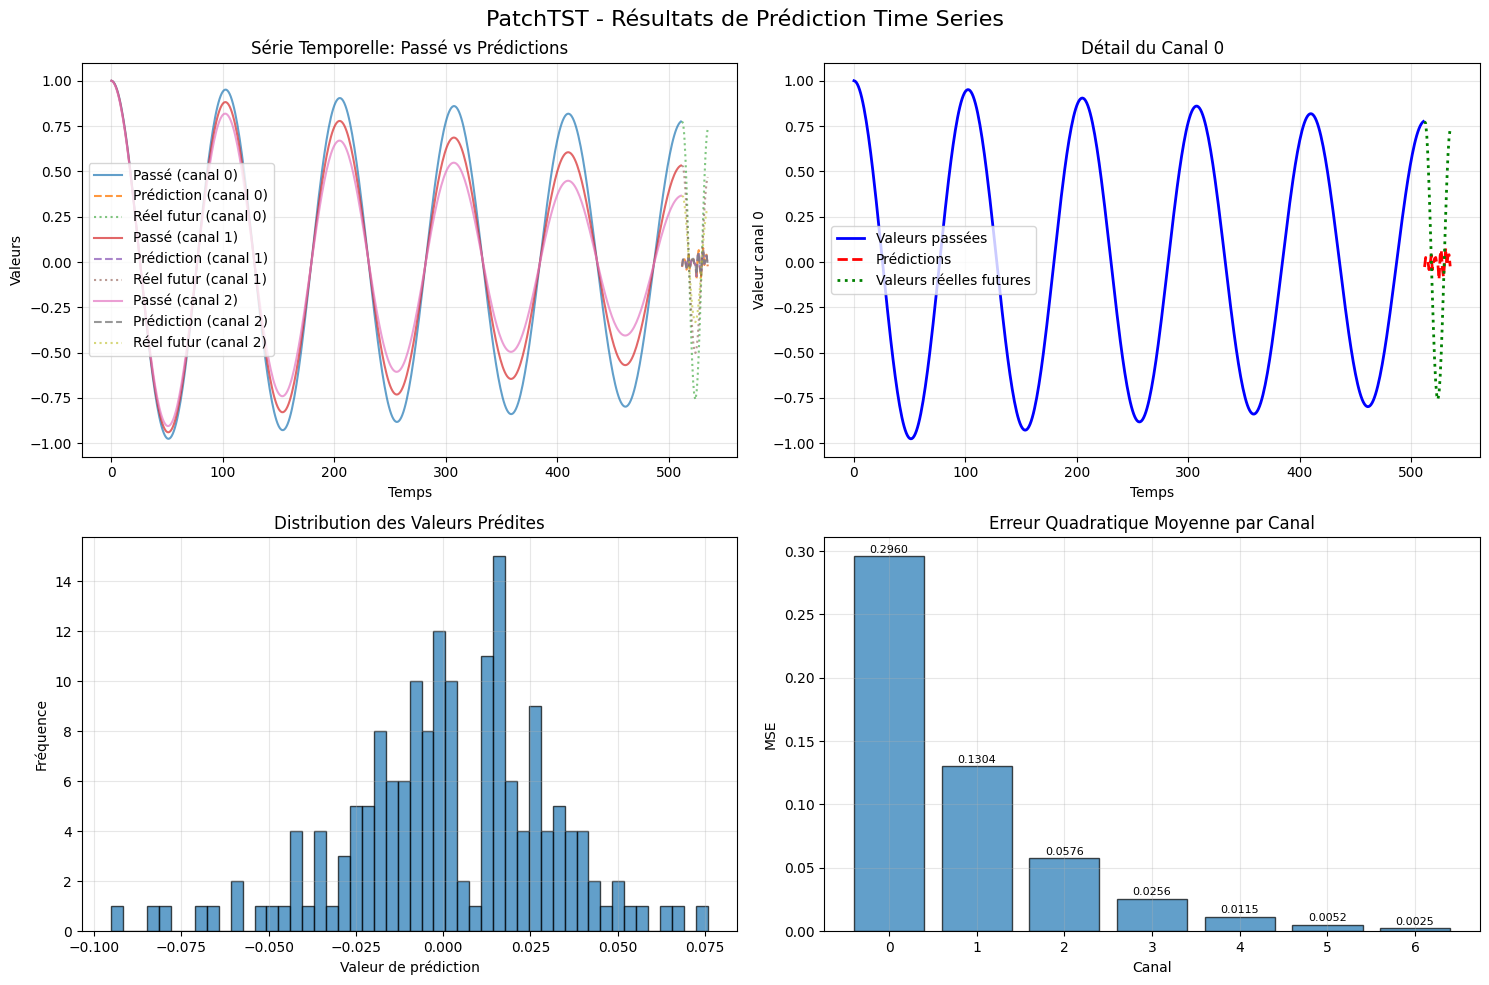

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('PatchTST - Résultats de Prédiction Time Series', fontsize=16)

# Graphique 1: Série temporelle complète avec prédictions
ax1 = axes[0, 0]
time_axis_past = np.arange(past_values_np.shape[1])
time_axis_future = np.arange(past_values_np.shape[1], 
                            past_values_np.shape[1] + predictions_np.shape[1])

# Affichage de quelques canaux sélectionnés
channels_to_plot = min(3, past_values_np.shape[2])  # Maximum 3 canaux

for i in range(channels_to_plot):
    ax1.plot(time_axis_past, past_values_np[0, :, i], 
             label=f'Passé (canal {i})', alpha=0.7)
    ax1.plot(time_axis_future, predictions_np[0, :, i], 
             '--', label=f'Prédiction (canal {i})', alpha=0.8)
    
    if "future_values" in batch:
        ax1.plot(time_axis_future, future_values_np[0, :, i], 
                 ':', label=f'Réel futur (canal {i})', alpha=0.6)

ax1.set_xlabel('Temps')
ax1.set_ylabel('Valeurs')
ax1.set_title('Série Temporelle: Passé vs Prédictions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Détail d'un canal spécifique
ax2 = axes[0, 1]
channel_to_detail = 0  # Premier canal

ax2.plot(time_axis_past, past_values_np[0, :, channel_to_detail], 
         'b-', label='Valeurs passées', linewidth=2)
ax2.plot(time_axis_future, predictions_np[0, :, channel_to_detail], 
         'r--', label='Prédictions', linewidth=2)

if "future_values" in batch:
    ax2.plot(time_axis_future, future_values_np[0, :, channel_to_detail], 
             'g:', label='Valeurs réelles futures', linewidth=2)

ax2.set_xlabel('Temps')
ax2.set_ylabel(f'Valeur canal {channel_to_detail}')
ax2.set_title(f'Détail du Canal {channel_to_detail}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Graphique 3: Distribution des prédictions
ax3 = axes[1, 0]
all_predictions = predictions_np.flatten()
ax3.hist(all_predictions, bins=50, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Valeur de prédiction')
ax3.set_ylabel('Fréquence')
ax3.set_title('Distribution des Valeurs Prédites')
ax3.grid(True, alpha=0.3)

# Graphique 4: Métriques par canal (si valeurs futures disponibles)
ax4 = axes[1, 1]
if "future_values" in batch:
    mse_by_channel = np.mean((predictions_np - future_values_np) ** 2, axis=1)[0]
    channels = range(len(mse_by_channel))
    
    bars = ax4.bar(channels, mse_by_channel, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Canal')
    ax4.set_ylabel('MSE')
    ax4.set_title('Erreur Quadratique Moyenne par Canal')
    ax4.grid(True, alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for bar, value in zip(bars, mse_by_channel):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom', fontsize=8)
else:
    # Graphique alternatif: amplitudes par canal
    amplitudes = np.ptp(predictions_np, axis=1)[0]  # Peak-to-peak
    channels = range(len(amplitudes))
    
    bars = ax4.bar(channels, amplitudes, alpha=0.7, edgecolor='black', color='orange')
    ax4.set_xlabel('Canal')
    ax4.set_ylabel('Amplitude (max-min)')
    ax4.set_title('Amplitude des Prédictions par Canal')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [18]:
print(f"Forme des données passées: {batch['past_values'].shape}")
print(f"Forme des prédictions: {predictions.shape}")
print(f"Longueur de prédiction: {predictions.shape[1]} pas de temps")
print(f"Nombre de canaux: {predictions.shape[2]}")

if "future_values" in batch:
    print(f"Forme des valeurs futures réelles: {batch['future_values'].shape}")
    
    # Calcul des métriques globales
    mse_total = np.mean((predictions_np - future_values_np) ** 2)
    print(f"MSE total: {mse_total:.6f}")

Forme des données passées: torch.Size([64, 512, 7])
Forme des prédictions: torch.Size([64, 24, 7])
Longueur de prédiction: 24 pas de temps
Nombre de canaux: 7
Forme des valeurs futures réelles: torch.Size([64, 96, 7])


ValueError: operands could not be broadcast together with shapes (64,24,7) (64,96,7) 

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from transformers import PatchTSTForPrediction, PatchTSTConfig
from sklearn.preprocessing import StandardScaler

In [ ]:
dataset = "ETTh1"

In [ ]:
print(f"Loading target dataset: {dataset}")
dataset_path = f"https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/{dataset}.csv"
timestamp_column = "date"
id_columns = []
forecast_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
train_start_index = None  # None indicates beginning of dataset
train_end_index = 12 * 30 * 24

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
valid_start_index = 12 * 30 * 24 - context_length
valid_end_index = 12 * 30 * 24 + 4 * 30 * 24

test_start_index = 12 * 30 * 24 + 4 * 30 * 24 - context_length
test_end_index = 12 * 30 * 24 + 8 * 30 * 24

In [ ]:
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=True,
)
time_series_preprocessor = time_series_preprocessor.train(train_data)

In [ ]:
train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
valid_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(valid_data),
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
test_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(test_data),
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)

In [ ]:
finetune_forecast_model = PatchTSTForPrediction.from_pretrained(
    "patchtst/electricity/model/pretrain/",
    num_input_channels=len(forecast_columns),
    head_dropout=0.7,
)

In [ ]:
finetune_forecast_args = TrainingArguments(
    output_dir="./checkpoint/patchtst/transfer/finetune/output/",
    overwrite_output_dir=True,
    learning_rate=0.0001,
    num_train_epochs=100,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    report_to="tensorboard",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="./checkpoint/patchtst/transfer/finetune/logs/",  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create a new early stopping callback with faster convergence properties
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
)

print("\n\nDoing zero-shot forecasting on target data")
result = finetune_forecast_trainer.evaluate(test_dataset)
print("Target data zero-shot forecasting result:")
print(result)


In [ ]:
# Freeze the backbone of the model
for param in finetune_forecast_trainer.model.model.parameters():
    param.requires_grad = False

print("\n\nLinear probing on the target data")
finetune_forecast_trainer.train()
print("Evaluating")
result = finetune_forecast_trainer.evaluate(test_dataset)
print("Target data head/linear probing result:")
print(result)

In [ ]:
def generate_damped_oscillation(length=1000, freq=0.1, decay=0.01):
    t = np.arange(length)
    oscillation = np.sin(2 * np.pi * freq * t) * np.exp(-decay * t)
    return oscillation

In [ ]:
# Paramètres
total_length = 1000
context_length = 512  # Doit correspondre à l'entraînement du modèle
prediction_length = 96  # Doit correspondre à l'entraînement du modèle

# Génération des données
full_series = generate_damped_oscillation(length=total_length)

In [ ]:
# 2. Préparation des données pour le modèle
# Normalisation des données
scaler = StandardScaler()
full_series_scaled = scaler.fit_transform(full_series.reshape(-1, 1)).flatten()

# Séparation en données passées (contexte) et futures (à prédire)
past_values = full_series_scaled[:context_length]
future_values = full_series_scaled[context_length:context_length+prediction_length]

# Conversion en tenseurs PyTorch
past_values_tensor = torch.FloatTensor(past_values).unsqueeze(0).unsqueeze(-1)  # Shape: (1, context_length, 1)

In [ ]:
# 3. Chargement du modèle PatchTST pré-entraîné
model_name = "namctin/patchtst_etth1_forecast"
model = PatchTSTForPrediction.from_pretrained(model_name)
model.eval()


In [ ]:
# 4. Prédiction du futur
with torch.no_grad():
    outputs = model(past_values=past_values_tensor)
    predictions = outputs.prediction_outputs.squeeze().numpy()

# Dénormalisation des prédictions
predictions_denormalized = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [ ]:
# Préparation des données pour le graphique
past_denormalized = scaler.inverse_transform(past_values.reshape(-1, 1)).flatten()
future_actual_denormalized = scaler.inverse_transform(future_values.reshape(-1, 1)).flatten()

time_past = np.arange(context_length)
time_future = np.arange(context_length, context_length + prediction_length)

In [ ]:
# 5. Affichage des résultats
plt.figure(figsize=(12, 6))
plt.plot(time_past, past_denormalized, label='Passé connu', color='blue')
plt.plot(time_future, future_actual_denormalized, label='Futur réel', color='green', linestyle='--')
plt.plot(time_future, predictions_denormalized, label='Prédiction PatchTST', color='red')
plt.title('Prédiction d\\'une oscillation amortie avec PatchTST')
plt.xlabel('Temps')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()